In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# 使用白酒数据集
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [62]:
# 对数据进行标准化
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [63]:
x, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [65]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [66]:
# 计算平均向量
np.set_printoptions(precision=4) # 设置打印显示方式
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(x_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [67]:
# 计算散点矩阵
d = 13 # 特征维度
s_w = np.zeros((d,d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in x[y==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    s_w += class_scatter
print('within-class scatter matrix: %sx%s' %(s_w.shape[0], s_w.shape[1]))

within-class scatter matrix: 13x13


In [68]:
# 计算协方差矩阵(散点矩阵的归一化结果)
d = 13 # 特征维度
s_w = np.zeros((d,d))
for label, mv, in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(x_train_std[y_train==label].T)
    s_w += class_scatter
print('Scaled within-class scatter matrix: %sx%s' %(s_w.shape[0], s_w.shape[1]))

Scaled within-class scatter matrix: 13x13


In [69]:
# 计算类间散点矩阵
mean_overall = np.mean(x_train_std, axis=0)
d = 13
s_b = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = x[y==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    s_b += n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Beteeen-class scatter matrix: %sx%s' %(s_w.shape[0], s_w.shape[1]))

Beteeen-class scatter matrix: 13x13


In [70]:
# 为特征子空间选择线性判别式
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))

In [71]:
# 得到特征之后,对其降序排序
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [72]:
print("Eigenvalus in decreasing order: \n")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalus in decreasing order: 

643.0153843460513
225.08698185416247
8.968842053905322e-14
8.430868489143321e-14
4.618527782440651e-14
3.523773495259293e-14
3.523773495259293e-14
2.8863335133489555e-14
2.8863335133489555e-14
1.3277731798187954e-14
1.3277731798187954e-14
6.5123724122531044e-15
3.017463642352754e-16


In [73]:
# 为了度量线性判别式(特征向量)捕捉到了多少类别信息,我们画出线性判别图
tot = sum(eigen_vals.real)

In [74]:
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

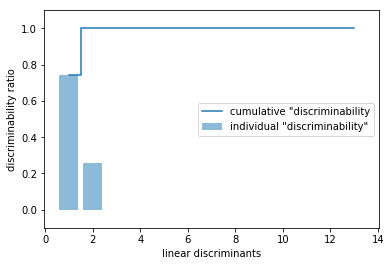

In [75]:
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability')
plt.ylabel('discriminability ratio')
plt.xlabel('linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [76]:
# 由上面两个线性判别式来创建转化矩阵W:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

In [77]:
print("Matrix W:\n", w)

Matrix W:
 [[-0.0707  0.3778]
 [ 0.0359  0.2223]
 [-0.0263  0.3813]
 [ 0.1875 -0.2955]
 [-0.0033 -0.0143]
 [ 0.2328 -0.0151]
 [-0.7719 -0.2149]
 [-0.0803 -0.0726]
 [ 0.0896 -0.1767]
 [ 0.1815  0.2909]
 [-0.0631 -0.2376]
 [-0.3794 -0.0867]
 [-0.3355  0.586 ]]


In [78]:
# 将原始数据映射到新特征空间

In [79]:
x_train_lda = x_train_std.dot(w)

In [80]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

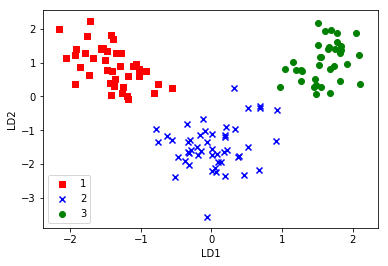

In [84]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(x_train_lda[y_train==l, 0],
               x_train_lda[y_train==l, 1],
               c=c, label=l, marker=m)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

In [86]:
# 调用sklearn中的LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [87]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [89]:
x_train_lda = lda.fit_transform(x_train_std, y_train)

In [90]:
# 使用逻辑斯蒂回归建模
from sklearn.linear_model import LogisticRegression

In [91]:
lr = LogisticRegression()

In [92]:
lr = lr.fit(x_train_lda, y_train)

In [95]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(x, y, classifier, resolution=0.02):
    # 设置标记和颜色
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 绘制决策面
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # 绘制分类样本
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y==cl, 0], y=x[y==cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)

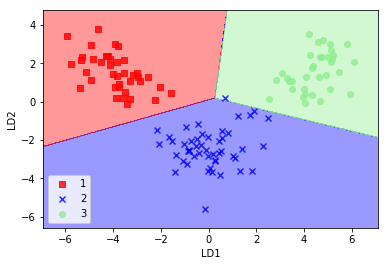

In [97]:
plot_decision_regions(x_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()